In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import folium
from folium import plugins
from folium.plugins import MarkerCluster
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap
import tabulate as tabulate

#Importing and Data Wrangling

In [2]:
bike_master = pd.read_csv('bike_full.csv', dtype={5: str, 7: str})  # Convert both columns to strings


In [3]:
bike_hourly = pd.read_csv('hourly_weather.csv')

In [4]:
bike_master_clean = bike_master.copy()

# Convert datetime columns
bike_master_clean['started_at'] = pd.to_datetime(bike_master_clean['started_at'])
bike_master_clean['ended_at'] = pd.to_datetime(bike_master_clean['ended_at'])

# Convert category columns
category_columns = ['rideable_type', 'start_station_name', 'end_station_name', 'member_casual']
for col in category_columns:
    bike_master_clean[col] = bike_master_clean[col].astype('category')

# Convert string columns (IDs)
string_columns = ['ride_id', 'start_station_id', 'end_station_id']
for col in string_columns:
    bike_master_clean[col] = bike_master_clean[col].astype('string')

In [5]:
#finding null values
bike_master_clean.isnull().sum()


ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    742776
start_station_id      742776
end_station_name      811282
end_station_id        811282
start_lat                  2
start_lng                  2
end_lat                16765
end_lng                16765
member_casual              0
dtype: int64

In [7]:
#finding unique values for few columns
bike_master_clean[['start_station_name', 'end_station_name', 'start_station_id', 'end_station_id','start_lat']].nunique()

start_station_name       860
end_station_name         865
start_station_id        1321
end_station_id          1338
start_lat             570110
dtype: int64

In [19]:
#create a new column for month year
bike_master_clean['month_year'] = bike_master_clean['started_at'].dt.to_period('M')

#create a new column for year
bike_master_clean['year'] = bike_master_clean['started_at'].dt.year

#create a new dataframe for the month june 2023 to december 2023
bike_master_clean_2023 = bike_master_clean[(bike_master_clean['year'] == 2023)]

row_count = len(bike_master_clean_2023)
print(f"Number of rows in the dataset: {row_count}")

Number of rows in the dataset: 4467334


In [20]:
#find missing null values
print(bike_master_clean_2023.isnull().sum())

#drop missing values
bike_master_clean_2023 = bike_master_clean_2023.dropna()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    406630
start_station_id      406630
end_station_name      432484
end_station_id        432484
start_lat                  0
start_lng                  0
end_lat                 5945
end_lng                 5945
member_casual              0
month_year                 0
year                       0
dtype: int64


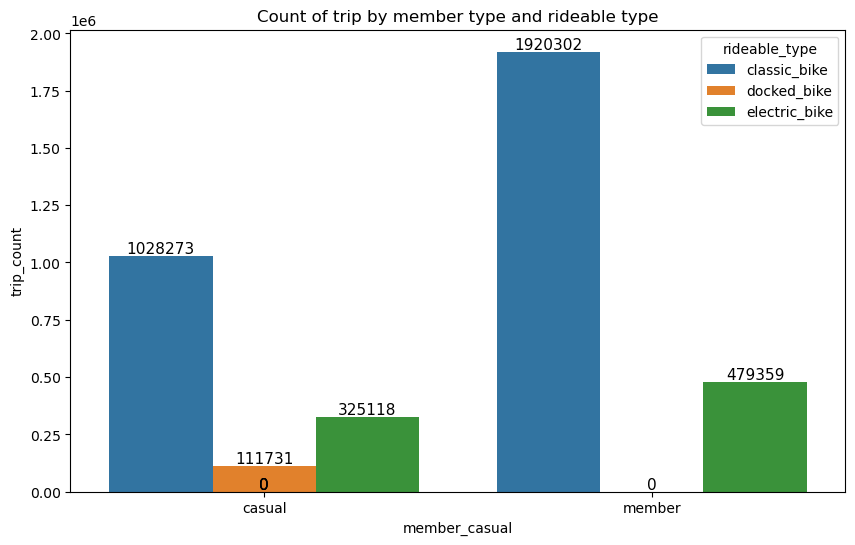

In [31]:
#Count of trip by member type and rideable type by ride id
member_rideable = (
    bike_master_clean_2023
    .groupby(['member_casual', 'rideable_type'], observed=False)
    .agg(trip_count=('ride_id', 'count'))
    .reset_index()
)

#plotting the count of trip by member type and rideable type
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='member_casual', y='trip_count', hue='rideable_type', data=member_rideable)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Count of trip by member type and rideable type')
plt.show()


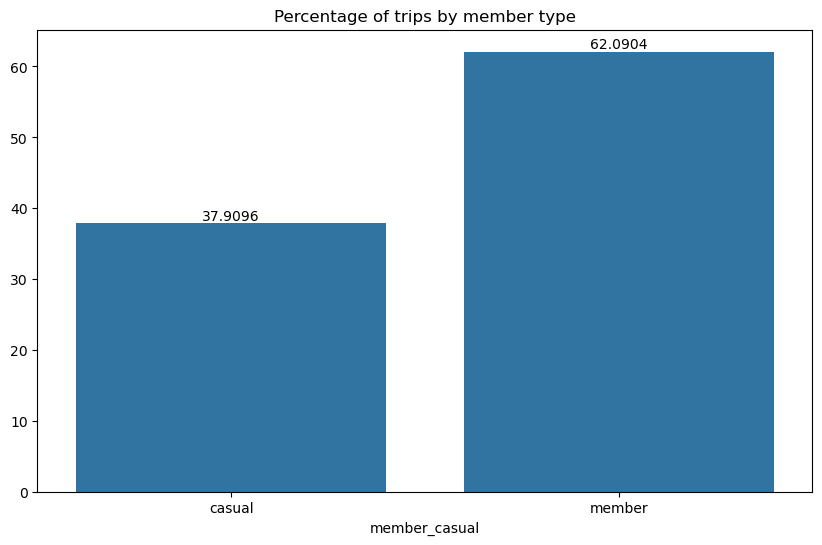

In [26]:
#calculating the num  of trips by member type
trip_counts = bike_master_clean_2023['member_casual'].value_counts()

#calculating the percentage of trips by member type
trip_percent = (trip_counts / trip_counts.sum()) * 100

trip_percent

#plotting the percentage of trips by member type
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=trip_percent.index, y=trip_percent.values)
ax.bar_label(ax.containers[0])
plt.title('Percentage of trips by member type')
plt.show()


In [41]:
#calculate the average duration of trips by member type

bike_master_clean_2023['duration'] = (bike_master_clean_2023['ended_at'] - bike_master_clean_2023['started_at']).dt.total_seconds() / 60

#group by member type and calculate the average duration
avg_duration = (
    bike_master_clean_2023
    .groupby('member_casual', observed=False)
    .agg(avg_duration=('duration', 'mean'))
    .reset_index()
)

avg_duration

,member_casual,avg_duration
0,casual,28.179683
1,member,12.795157


rideable_type             classic_bike  docked_bike  electric_bike
member_casual month_year                                          
casual        2023-01        80.692666    11.505928       7.801406
              2023-02        79.232897    10.800268       9.966834
              2023-03        75.488542    12.912231      11.599227
              2023-04        67.000302    12.021186      20.978512
              2023-05        68.285318    10.210936      21.503746
              2023-06        70.862804    10.119652      19.017543
              2023-07        71.088499     9.999492      18.912009
              2023-08        69.238060     9.056499      21.705441
              2023-09        73.862082     3.199563      22.938354
              2023-10        69.640946     0.000000      30.359054
              2023-11        63.628869     0.000000      36.371131
              2023-12        58.052512     0.000000      41.947488
member        2023-01        93.423557     0.000000       6.57

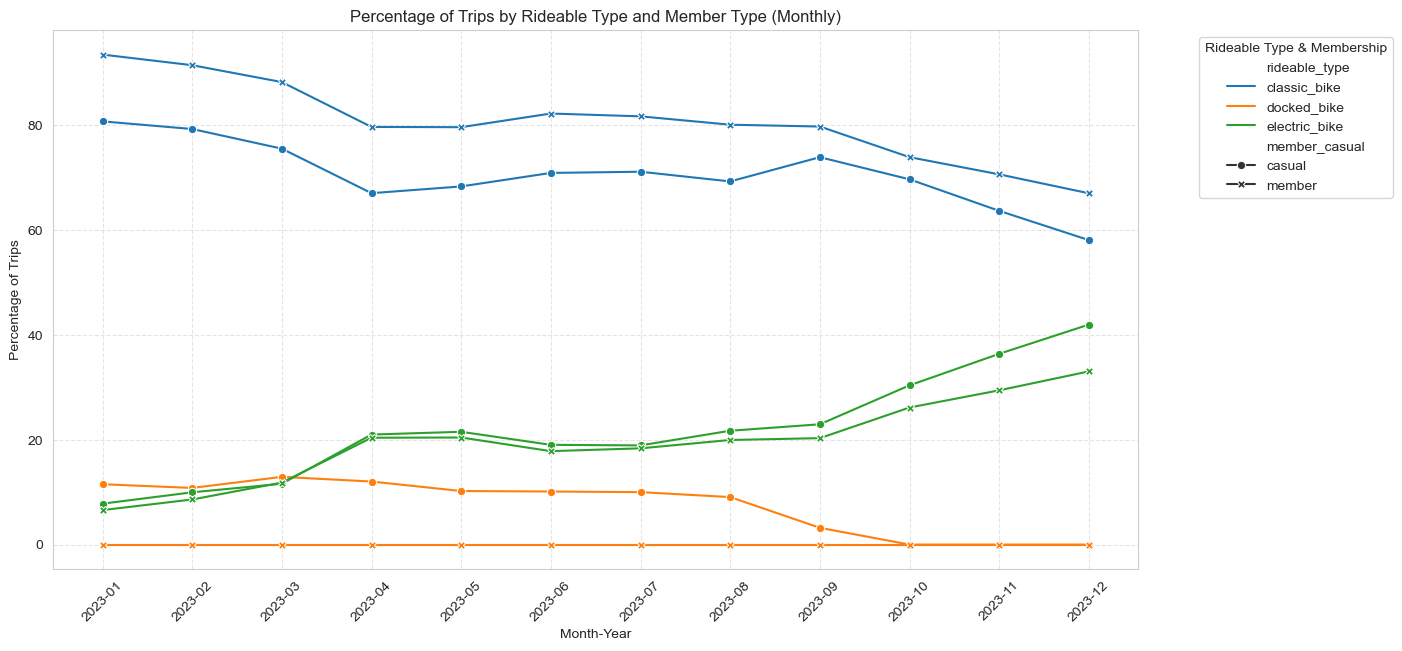

In [52]:
# Group by month and rideable type, then count trips
monthly_rideable_type = bike_master_clean_2023.groupby(['member_casual','month_year', 'rideable_type'],observed=False).size().unstack(fill_value=0)

# Calculate percentage of trips by rideable type per month
monthly_rideable_type_percent = (monthly_rideable_type.div(monthly_rideable_type.sum(axis=1), axis=0)) * 100

# Display result
print(monthly_rideable_type_percent)


# Set Seaborn style
sns.set_style("whitegrid")

# Convert month_year to string for plotting
monthly_rideable_type_percent = monthly_rideable_type_percent.reset_index()
monthly_rideable_type_percent['month_year'] = monthly_rideable_type_percent['month_year'].astype(str)

# Create line plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=monthly_rideable_type_percent.melt(id_vars=['member_casual', 'month_year'], var_name='rideable_type', value_name='percentage'),
    x="month_year", 
    y="percentage", 
    hue="rideable_type", 
    style="member_casual", 
    markers=True, 
    dashes=False
)

# Labels and Title
plt.ylabel("Percentage of Trips")
plt.xlabel("Month-Year")
plt.title("Percentage of Trips by Rideable Type and Member Type (Monthly)")
plt.xticks(rotation=45)
plt.legend(title="Rideable Type & Membership", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

rideable_type             classic_bike  docked_bike  electric_bike
member_casual month_year                                          
casual        2021-01        53.338126    13.792794      32.869081
              2021-02        51.089832    11.587082      37.323086
              2021-03        57.073474    19.205325      23.721201
              2021-04        56.736447    19.518124      23.745430
              2021-05        56.885030    18.380251      24.734719
...                                ...          ...            ...
member        2023-08        68.362692     0.000000      31.637308
              2023-09        67.104817     0.000000      32.895183
              2023-10        60.275382     0.000000      39.724618
              2023-11        55.711748     0.000000      44.288252
              2023-12        50.813429     0.000000      49.186571

[72 rows x 3 columns]


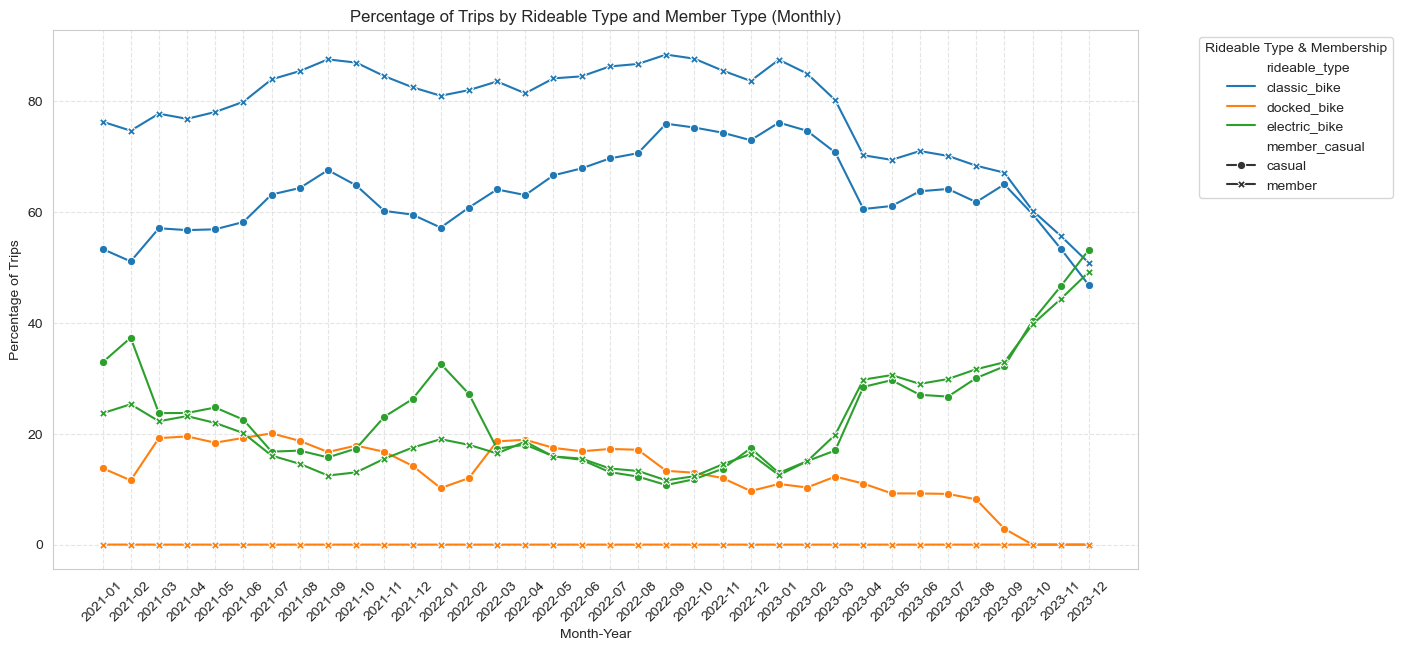

In [53]:
# Group by month and rideable type, then count trips
monthly_rideable_type = bike_master_clean.groupby(['member_casual','month_year', 'rideable_type'],observed=False).size().unstack(fill_value=0)

# Calculate percentage of trips by rideable type per month
monthly_rideable_type_percent = (monthly_rideable_type.div(monthly_rideable_type.sum(axis=1), axis=0)) * 100

# Display result
print(monthly_rideable_type_percent)


# Set Seaborn style
sns.set_style("whitegrid")

# Convert month_year to string for plotting
monthly_rideable_type_percent = monthly_rideable_type_percent.reset_index()
monthly_rideable_type_percent['month_year'] = monthly_rideable_type_percent['month_year'].astype(str)

# Create line plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=monthly_rideable_type_percent.melt(id_vars=['member_casual', 'month_year'], var_name='rideable_type', value_name='percentage'),
    x="month_year", 
    y="percentage", 
    hue="rideable_type", 
    style="member_casual", 
    markers=True, 
    dashes=False
)

# Labels and Title
plt.ylabel("Percentage of Trips")
plt.xlabel("Month-Year")
plt.title("Percentage of Trips by Rideable Type and Member Type (Monthly)")
plt.xticks(rotation=45)
plt.legend(title="Rideable Type & Membership", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()